Подключим необходимые пакеты

In [1]:
import datetime as dt
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

%pylab inline
pylab.rcParams['figure.figsize'] = (18, 6)

Populating the interactive namespace from numpy and matplotlib


Загрузим данные за май 2016 года и выведем основную информацию о них.

In [2]:
data = pd.read_csv("../yellow_tripdata_2016-05.csv")
data['tpep_pickup_datetime'] = pd.to_datetime(data['tpep_pickup_datetime'])
data['tpep_dropoff_datetime'] = pd.to_datetime(data['tpep_dropoff_datetime'])

In [3]:
data.shape

(11836853, 19)

In [4]:
data.dtypes

VendorID                          int64
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                   int64
trip_distance                   float64
pickup_longitude                float64
pickup_latitude                 float64
RatecodeID                        int64
store_and_fwd_flag               object
dropoff_longitude               float64
dropoff_latitude                float64
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
dtype: object

In [5]:
data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,1,2016-05-01,2016-05-01 00:17:31,1,3.60,-73.985901,40.768040,1,N,-73.983986,40.730099,1,15.0,0.5,0.5,1.50,0.0,0.3,17.80
1,2,2016-05-01,2016-05-01 00:07:31,1,1.68,-73.991577,40.744751,1,N,-73.975700,40.765469,1,7.5,0.5,0.5,0.88,0.0,0.3,9.68
2,2,2016-05-01,2016-05-01 00:07:01,6,1.09,-73.993073,40.741573,1,N,-73.980995,40.744633,1,6.5,0.5,0.5,1.56,0.0,0.3,9.36
3,2,2016-05-01,2016-05-01 00:19:47,1,4.21,-73.991943,40.684601,1,N,-74.002258,40.733002,1,17.0,0.5,0.5,3.66,0.0,0.3,21.96
4,2,2016-05-01,2016-05-01 00:06:39,1,0.56,-74.005280,40.740192,1,N,-73.997498,40.737564,1,6.0,0.5,0.5,1.46,0.0,0.3,8.76


Проведем фильтрацию данных. Отбросим данные с:
  - нулевой длительностью
  - нулевым количеством пассажиров
  - нулевым расстоянием поездки по счётчику
  - координатами начала, не попадающими в прямоугольник Нью-Йорка

In [6]:
new_york_longitude = (-74.25559, -73.70001)
new_york_latitude = (40.49612, 40.91553)

data.drop(data[data.tpep_dropoff_datetime == data.tpep_pickup_datetime].index, inplace=True)
data.drop(data[data.passenger_count == 0].index, inplace=True)
data.drop(data[data.trip_distance == 0].index, inplace=True)
data.drop(data[(data.pickup_longitude < new_york_longitude[0]) |
               (data.pickup_longitude > new_york_longitude[1]) |
               (data.pickup_latitude < new_york_latitude[0]) |
               (data.pickup_latitude > new_york_latitude[1])].index, inplace=True)

In [7]:
data.shape

(11626521, 19)

In [8]:
data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,1,2016-05-01,2016-05-01 00:17:31,1,3.60,-73.985901,40.768040,1,N,-73.983986,40.730099,1,15.0,0.5,0.5,1.50,0.0,0.3,17.80
1,2,2016-05-01,2016-05-01 00:07:31,1,1.68,-73.991577,40.744751,1,N,-73.975700,40.765469,1,7.5,0.5,0.5,0.88,0.0,0.3,9.68
2,2,2016-05-01,2016-05-01 00:07:01,6,1.09,-73.993073,40.741573,1,N,-73.980995,40.744633,1,6.5,0.5,0.5,1.56,0.0,0.3,9.36
3,2,2016-05-01,2016-05-01 00:19:47,1,4.21,-73.991943,40.684601,1,N,-74.002258,40.733002,1,17.0,0.5,0.5,3.66,0.0,0.3,21.96
4,2,2016-05-01,2016-05-01 00:06:39,1,0.56,-74.005280,40.740192,1,N,-73.997498,40.737564,1,6.0,0.5,0.5,1.46,0.0,0.3,8.76


Отбросим минуты и секунды во времени начала поездки.

In [9]:
data['tpep_pickup_datetime'] = data['tpep_pickup_datetime'].apply(lambda x: x.replace(minute = 0, second = 0))

Загрузим данные о разбиении Нью-Йорка на регионы и посчитаем необходимые границы бинов в 2d гистограмме.

In [10]:
regions = pd.read_csv("../regions.csv", delimiter=';')
regions.head()

,region,west,east,south,north
0,1,-74.25559,-74.244478,40.496120,40.504508
1,2,-74.25559,-74.244478,40.504508,40.512896
2,3,-74.25559,-74.244478,40.512896,40.521285
3,4,-74.25559,-74.244478,40.521285,40.529673
4,5,-74.25559,-74.244478,40.529673,40.538061


In [11]:
binx = regions['west'].append(regions['east']).unique()
biny = regions['south'].append(regions['north']).unique()

Посчитаем количество поездок за каждый час из каждой области. Для начала определим в какой регион попала каждая из поездок.

In [12]:
agg2d = stats.binned_statistic_2d(data.pickup_longitude, data.pickup_latitude, None,
                                'count', bins = [binx, biny], expand_binnumbers=True)

Создадим новый датафрейм, в котором будем хранить количество поездок по часам по регионам.

In [13]:
agg = pd.DataFrame(index = pd.date_range(start = dt.datetime(2016, 5, 1), periods = 31 * 24, freq = '1H'),
                   columns = [i for i in range(1, 2501)],
                   dtype = np.int64)
agg.fillna(0, inplace=True)
agg.head()

,1,2,3,4,5,6,7,8,9,10,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
2016-05-01 00:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-05-01 01:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-05-01 02:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-05-01 03:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-05-01 04:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Агрегируем наши данные в новые датафрейме, где строчки будут датами поездок, колонки - регионами, а значения ячеек - количеством поездок из заданного региона в конкретный момент времени.

In [14]:
data['region'] = (agg2d.binnumber[0] - 1) * 50 + agg2d.binnumber[1]
grouped = data.groupby(['region', 'tpep_pickup_datetime'], as_index=False)
rides = grouped.size().unstack(level=0, fill_value=0)
rides.index.name = None
rides.columns.name = None
agg.update(rides)

pd.set_option('display.max_columns', None)  
agg.head()

1     2     3     4     5     6     7     8     9     \
2016-05-01 00:00:00     0     0     0     0     0     0     0     0     0   
2016-05-01 01:00:00     0     0     0     0     0     0     0     0     0   
2016-05-01 02:00:00     0     0     0     0     0     0     0     0     0   
2016-05-01 03:00:00     0     0     0     0     0     0     0     0     0   
2016-05-01 04:00:00     0     0     0     0     0     0     0     0     0   

                     10    11    12    13    14    15    16    17    18    \
2016-05-01 00:00:00     0     0     0     0     0     0     0     0     0   
2016-05-01 01:00:00     0     0     0     0     0     0     0     0     0   
2016-05-01 02:00:00     0     0     0     0     0     0     0     0     0   
2016-05-01 03:00:00     0     0     0     0     0     0     0     0     0   
2016-05-01 04:00:00     0     0     0     0     0     0     0     0     0   

                     19    20    21    22    23    24    25    26    27    \
2016-05-01 00:00:00     0     0     0     0     0     0     0     0     0   
2016-05-01 01:00:00     0     0     0     0     0     0     0     0     0   
2016-05-01 02:00:00     0     0     0     0     0     0     0     0     0   
2016-05-01 03:00:00     0     0     0     0     0     0     0     0     0   
2016-05-01 04:00:00     0     0     0     0     0     0     0     0     0   

                     28    29    30    31    32    33    34    35    36    \
2016-05-01 00:00:00     0     0     0     0     0     0     0     0     0   
2016-05-01 01:00:00     0     0     0     0     0     0     0     0     0   
2016-05-01 02:00:00     0     0     0     0     0     0     0     0     0   
2016-05-01 03:00:00     0     0     0     0     0     0     0     0     0   
2016-05-01 04:00:00     0     0     0     0     0     0     0     0     0   

                     37    38    39    40    41    42    43    44    45    \
2016-05-01 00:00:00     0     0     0     0     0     0     0     0     0   
2016-05-01 01:00:00     0     0     0     0     0     0     0     0     0   
2016-05-01 02:00:00     0     0     0     0     0     0     0     0     0   
2016-05-01 03:00:00     0     0     0     0     0     0     0     0     0   
2016-05-01 04:00:00     0     0     0     0     0     0     0     0     0   

                     46    47    48    49    50    51    52    53    54    \
2016-05-01 00:00:00     0     0     0     0     0     0     0     0     0   
2016-05-01 01:00:00     0     0     0     0     0     0     0     0     0   
2016-05-01 02:00:00     0     0     0     0     0     0     0     0     0   
2016-05-01 03:00:00     0     0     0     0     0     0     0     0     0   
2016-05-01 04:00:00     0     0     0     0     0     0     0     0     0   

                     55    56    57    58    59    60    61    62    63    \
2016-05-01 00:00:00     0     0     0     0     0     0     0     0     0   
2016-05-01 01:00:00     0     0     0     0     0     0     0     0     0   
2016-05-01 02:00:00     0     0     0     0     0     0     0     0     0   
2016-05-01 03:00:00     0     0     0     0     0     0     0     0     0   
2016-05-01 04:00:00     0     0     0     0     0     0     0     0     0   

                     64    65    66    67    68    69    70    71    72    \
2016-05-01 00:00:00     0     0     0     0     0     0     0     0     0   
2016-05-01 01:00:00     0     0     0     0     0     0     0     0     0   
2016-05-01 02:00:00     0     0     0     0     0     0     0     0     0   
2016-05-01 03:00:00     0     0     0     0     0     0     0     0     0   
2016-05-01 04:00:00     0     0     0     0     0     0     0     0     0   

                     73    74    75    76    77    78    79    80    81    \
2016-05-01 00:00:00     0     0     0     0     0     0     0     0     0   
2016-05-01 01:00:00     0     0     0     0     0     0     0     0     0   
2016-05-01 02:00:00     0     0     0     0     0     0     0     0     0   
2016-05-0

Построим график количества поездок жёлтого такси из ячейки, содержащей Empire State Building.
Координаты Empire State Building: 40.7484° N, 73.9857° W, что соответствует ячейке 1231

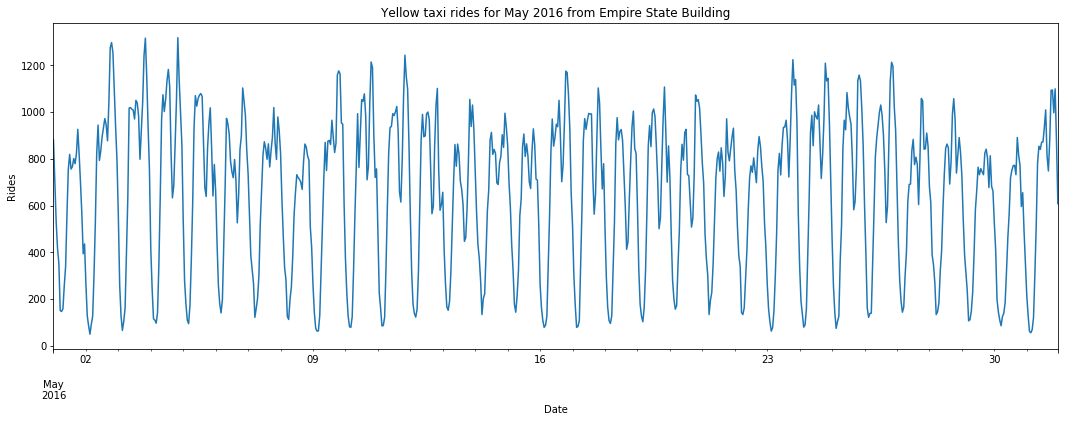

In [15]:
agg[1231].plot()
plt.title("Yellow taxi rides for May 2016 from Empire State Building")
plt.ylabel("Rides")
plt.xlabel("Date")

Посчитаем сколько в мае 2016 было пар час-ячейка, для которых не было совершено ни одной поездки.

In [16]:
print "Total hour-region cells:", agg.shape[0] * agg.shape[1]
print "Hour-region cells with zero rides:", (agg == 0).astype(int).values.sum()

Total hour-region cells: 1860000
Hour-region cells with zero rides: 1718238


Из полученных результатов можно сделать вывод, что большинство поездок совершается из небольшого количества ячеек.

In [17]:
regions.to_pickle("../regions.pickle")
agg.to_pickle("../yellow_tripdata_2016-05.pickle")